<a href="https://colab.research.google.com/github/sharmaa4/Twitter-Bot-for-Research-Paper-Summarization-using-Natural-Language-Processing/blob/main/Final_Submisision_of_Research_Paper_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SETUP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -Uq fastbook
!rm -rf /content/pdfminer.six
!pip install pdfminer.six

import os
import pandas as pd
import numpy as np
import requests

import tweepy
import webbrowser
import time

from lxml import etree
from tqdm.auto import tqdm
from fastai.text.all import *
!git clone "https://github.com/pdfminer/pdfminer.six"
!pip install pdfminer.six
!pip install -Uq transformers
!pip install -r '/content/drive/MyDrive/Colab Notebooks/requirements.txt'

## XML PARSING TO CONVERT INPUT DATA IN XML FORMAT TO STRINGS AND APPENDING THEM INTO A CSV FILE

In [ ]:
root_path = '/content/drive/MyDrive/Colab Notebooks/scisummnet_release1.1__20190413/top1000_complete'

In [ ]:
pathlist = os.listdir(root_path)
# for folder in pathlist:
#   print(os.listdir(root_path+'/'+folder+'/summary'))

In [ ]:
parser = etree.XMLParser(remove_blank_text=True)

# papers
pap_text = []
summaries = []
for folder in tqdm(pathlist):
  tree = etree.parse(root_path+'/'+folder+'/Documents_xml/'+folder+'.xml', parser)
  paper = []
  for s in tree.iter():
    if s.text is not None: paper.append(s.text)

  with open(root_path+'/'+folder+'/summary/'+folder+'.gold.txt') as f:
    lines = f.read()

  pap_text.append(' '.join(paper))
  summaries.append(lines)

  0%|          | 0/1009 [00:00<?, ?it/s]

In [ ]:
scis_df = pd.DataFrame({'text':pap_text, 'summary':summaries})
type(scis_df['text'].iloc[0])

str

In [ ]:
scis_df.to_csv('./scisumm.csv', index=False)

In [ ]:
import numpy as np

# Manual train-test split
np.random.seed(10) # seed added 
msk = np.random.rand(len(scis_df)) < 0.8
msk
train_df = scis_df[msk]
test_df = scis_df[~msk]
train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/scisumm_train.csv')
test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/scisumm_test.csv')

## FINE-TUNING BART WITH HUGGINGFACE SCRIPT

In [ ]:
!git clone https://github.com/huggingface/transformers
os.chdir("/content/transformers")
!pwd
!pip install .

!python '/content/drive/MyDrive/Colab Notebooks/run_summarization.py' \
    --model_name_or_path facebook/bart-large-cnn \
    --do_train \
    --do_eval \
    --train_file '/content/drive/MyDrive/Colab Notebooks/scisumm_train.csv' \
    --validation_file '/content/drive/MyDrive/Colab Notebooks/scisumm_test.csv' \
    --text_column text \
    --summary_column summary \
    --source_prefix "summarize: " \
    --output_dir "/content/drive/MyDrive/Colab Notebooks/Summarization Output/" \
    --overwrite_output_dir \
    --per_device_train_batch_size=1 \
    --per_device_eval_batch_size=1 \
    --predict_with_generate

Cloning into 'transformers'...
remote: Enumerating objects: 79107, done.
remote: Counting objects: 100% (805/805), done.
remote: Compressing objects: 100% (472/472), done.
remote: Total 79107 (delta 434), reused 567 (delta 284), pack-reused 78302
Receiving objects: 100% (79107/79107), 62.68 MiB | 24.93 MiB/s, done.
Resolving deltas: 100% (56408/56408), done.
/content/transformers
Processing /content/transformers
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for transformers: filename=transformers-4.10.0

## MEASURING PERFORMANCE OF FINE-TUNED MODEL

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig

PATH = "/content/drive/MyDrive/Colab Notebooks/Summarization Output/"
#model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained(PATH, local_files_only=True)
#tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
tokenizer = BartTokenizer.from_pretrained(PATH, local_files_only=True)


In [ ]:
gen_summs = []
for paper in tqdm(test_df.text.values[:203]):
#for paper in tqdm(scis_df.text.values[:5]):

  ARTICLE_TO_SUMMARIZE = paper
  inputs = tokenizer([ARTICLE_TO_SUMMARIZE], max_length=1024, return_tensors='pt', truncation=True)

  # Generate Summary
  summary_ids = model.generate(inputs['input_ids'], num_beams=4, max_length=500, early_stopping=True)
  gen_summs.append([tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids])

gen_df = pd.DataFrame({'generated_summary':gen_summs})
gen_df.head()

gen_df.generated_summary = gen_df.generated_summary.apply(lambda x: x[0])
gen_df.head()

from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge2', 'rouge3'])
scores = []
#mod: sharmaa4 for i in range(500):
for i in range(203):
  
  scores.append(scorer.score(test_df.iloc[i].summary, gen_df.iloc[i].generated_summary))


r2r = []
r2f = []
r3f = []
#for i in range(250):
for i in range(203):
  r2r.append(scores[i]['rouge2'].recall)
  r2f.append(scores[i]['rouge2'].fmeasure)
  r3f.append(scores[i]['rouge3'].fmeasure)


print('rouge2 - recall: '+ str(np.mean(r2r)))
print('rouge2 - fmeasure: '+ str(np.mean(r2f)))
print('rouge3 - fmeasure: '+ str(np.mean(r3f)))

gen_df.to_csv('./nonpt_first500.csv', index=False)

## FUNCTION TO GENERATE SUMMARY 

In [ ]:
os.chdir("/content")

In [ ]:
!git clone "https://github.com/pdfminer/pdfminer.six"

fatal: destination path 'pdfminer.six' already exists and is not an empty directory.


In [ ]:
def gen_pdf_summary(url):

  print(url)
  !curl -o PDF {url}
  !python /content/pdfminer.six/tools/pdf2txt.py PDF > ./PDF_text

  with open("./PDF_text",'r') as file:
    text = file.read()
  
  inputs_1 = tokenizer(text[0:1024], max_length=1024, return_tensors='pt', truncation=True)
  inputs_2 = tokenizer(text[1025:2048], max_length=1024, return_tensors='pt', truncation=True)
  inputs_3 = tokenizer(text[2048:3072], max_length=1024, return_tensors='pt', truncation=True)
  inputs_4 = tokenizer(text[3072:], max_length=1024, return_tensors='pt', truncation=True)

  # Generate Summary
  summary_ids_1 = model.generate(inputs_1['input_ids'], num_beams=4, max_length=100, early_stopping=True)
  summary_1 = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids_1]

  summary_ids_2 = model.generate(inputs_2['input_ids'], num_beams=4, max_length=100, early_stopping=True)
  summary_2 = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids_2]

  summary_ids_3 = model.generate(inputs_3['input_ids'], num_beams=4, max_length=100, early_stopping=True)
  summary_3 = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids_3]

  summary_ids_4 = model.generate(inputs_4['input_ids'], num_beams=4, max_length=100, early_stopping=True)
  summary_4 = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids_4]
  
  return summary_1[0]+summary_2[0]+summary_3[0]+summary_4[0]





In [ ]:
#gen_pdf_summary("https://arxiv.org/pdf/1909.01716v3.pdf")

https://arxiv.org/pdf/1909.01716v3.pdf
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  614k  100  614k    0     0   423k      0  0:00:01  0:00:01 --:--:--  423k


'ScisummNet: A Large Annotated Corpus and Content-Impact Models\nFor Scientiﬁc Paper Summarization with Citation Networks\nRecent work in automatic summarization has achieved good results for news articles: single-Document Single-Document (SDS) summaries (Parveen, Ramsl, and Strube) and traditional citation-based summaries.\nOur large annotated corpus and hybrid methods provide a new framework for science-oriented paper summarization research.\nWe demonstrate the effectiveness of our corpus in producing large-scale manually-annotated summaries and the advantage of'

## TWITTER BOT

In [ ]:
# these are the necessary keys which we got from Twitter
##consumer_key = "Qm4Exmimzawm2WJ1wCIbBPDCK"
##consumer_secret = "jDW4rd4sqwWM0t0nkEUXoRQnXYfpQjnJt4vqaxVhtfIaUb9PN9"
##access_token = "1419176160127164417-hiXZsBeeONG7cUKDdkz28fvPlU5J6r"
##access_token_secret = "kiyMn8EoCM3FbAF0jNHCBA59TtblJndRKmICwFv0ATIKW"

consumer_key = "VXE0kwXAw2bUJ9dx5gnFNmLEG"
consumer_secret = "LiebjWsYOcOXHWFsTTcfyxmPf13vWEc7xsgmrkVMJ4uXupkdI4"
access_token = "1419176160127164417-C4b5obrAO2EpwFnWBKC6XtQ6SJWwrO"
access_token_secret = "6WvekVxHlnQ6GWKSq1APhVPq3GpQg9gAd0NDBpzfP5k5V"

In [ ]:
# as of now we need to get tweets from this user, so we pick his user ID
userID = "ak92501"

In [ ]:
# authorizing our twitter credentials
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [ ]:
# user_timeline extends tweets from particular user
tweets = api.user_timeline(screen_name=userID, 
                           # 200 is the maximum allowed count
                           count=200,
                           include_rts = True,
                           tweet_mode = 'extended'
                           )

In [ ]:
# these are the recent 10 tweets from AK
def extract_pdf_link_from_tweet():

  for info in tweets[14:15]:
    link = ""
    print("ID: {}".format(info.id))
    print(info.created_at)
    print(info.full_text)
    print("\n")
    pdf_link = re.search("pdf:.*",info.full_text)
     

    if(pdf_link != None):
      pdf_link_list = pdf_link.string.split("\n")
      for i in pdf_link_list:
         if("pdf: " in i) :
            print("PDF Link: ",i)
            link_list = i.split(" ")
            link = link_list[1]
          

  return link      


#extract_pdf_link_from_tweet()      

ID: 1420856997583413262
2021-07-29 21:21:21
RT @abidlabs: By now, you've probably heard about Hugging Face Spaces, a *free* way to host @Gradio demos, like this cool depth perception…




''

In [ ]:
import requests
def unshorten_url(url=""):
  
  session = requests.Session()  # so connections are recycled
  resp = session.head(url, allow_redirects=True)
  
  return resp.url

In [ ]:
# Posting on Twitter
def tweet_summary(tweet="",user_id=""):
  
  tweet_list = tweet.split('\n')
  tweet_list
  count = 0
  my_id="@Summarizer19 "
  for i in tweet_list[:-1] :
      count = count+1
      if(count == 1):
        head = "Requested By "+"@"+user_id+" "
        print(i)
        try:
          original_tweet = api.update_status(status=head+i)
        except tweepy.TweepError:
          print("Could not tweet due to some issue")
          break
      else:
        print(my_id+i)
        if(count == 2):
          try: 
            reply_tweet = api.update_status(status=my_id+i, 
                                 in_reply_to_status_id=original_tweet.id, 
                                 auto_populate_reply_metadata=False)
          except tweepy.TweepError:
            print("Could not tweet due to some issue")
            break
        else:
          try:
            reply_tweet = api.update_status(status=my_id+i, 
                                 in_reply_to_status_id=reply_tweet.id, 
                                 auto_populate_reply_metadata=False)
          except tweepy.TweepError:
            print("Could not tweet due to some issue")
            break
        
  count = 0      

#tweet_summary(gen_pdf_summary(unshorten_url(extract_pdf_link_from_tweet())),user_id="ak92501")

In [ ]:
api.list_direct_messages(1)

[DirectMessage(_api=<tweepy.api.API object at 0x7f7afc6b3190>, _json={'type': 'message_create', 'id': '1421023655350259719', 'created_timestamp': '1627633415435', 'message_create': {'target': {'recipient_id': '1419176160127164417'}, 'sender_id': '1321213011911004161', 'message_data': {'text': 'Hi', 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}}}}, type='message_create', id='1421023655350259719', created_timestamp='1627633415435', message_create={'target': {'recipient_id': '1419176160127164417'}, 'sender_id': '1321213011911004161', 'message_data': {'text': 'Hi', 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}}})]

In [ ]:
def lookup_for_dms():
  global latest_dm_timestamp
  
  

  messages = api.list_direct_messages(1)

  
    

  output_link = ""
  output_user_id = ""

  for message in messages:
     if(int(message.created_timestamp) <= int(latest_dm_timestamp)):
       break

     if(len(message.message_create['message_data']['entities']['urls']) != 0):
       print(message.message_create['message_data']['entities']['urls'])
       #link = str(message.message_create['message_data']['entities']['urls'])
       link = str(message.message_create['message_data']['entities']['urls'])
       list_link= link.split(",")
       #print(list_link[1])
       list_expanded_link = list_link[1].split(": ")
       if("arxiv.org" in list_expanded_link[1]):
         expanded_arxiv_link = list_expanded_link[1]
         print(expanded_arxiv_link)
         output_link = expanded_arxiv_link
       else:
         print("Not an arxiv link\n")

     else:
       print("DM does not have a link")


     if(len(message.message_create['message_data']['entities']['user_mentions']) != 0):
    
       user_mentions = str(message.message_create['message_data']['entities']['user_mentions'])

       user_mentions_list = user_mentions.split(",")
       screen_name = user_mentions_list[0].split(": ")
       user_name = screen_name[1]
    
       print("User_id: ",user_name)

       output_user_id = user_name
  
     else:
       print("No username provided")

  if(int(message.created_timestamp) > int(latest_dm_timestamp)):
    output = []  
    output.append(output_link) 
    output.append(output_user_id)
  
  else:
    output = []  
    output.append(None) 
    output.append(None)

  latest_dm_timestamp = message.created_timestamp

  
  

  print(message)

  

  return output

#latest_dm_timestamp = 0
#requests = lookup_for_dms() 
#if(requests[0] != None):
#  print("LINK:",requests[0])
#  print("LAST DM TIMESTAMP",latest_dm_timestamp)
#else:
#  print("No Link")
#  print("LAST DM TIMESTAMP",latest_dm_timestamp)
#tweet_summary(gen_pdf_summary(requests[0]),user_id=requests[1][1:-1])  
  

In [ ]:
import time
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

#latest_dm_timestamp = 0

while True:
  print("Hello\n")
  requests = lookup_for_dms()
  if(requests[0] != None ):
    if(requests[0] != ""):
      print("LINK:",requests[0])
      tweet_summary(gen_pdf_summary(requests[0]),user_id=requests[1][1:-1])
  else:
    print("No Link in the latest DM or Summary has been already posted for the current DM")
    

  
  logger.info("Waiting...")
  time.sleep(60)

## NOT IN USE

In [ ]:
gen_df = pd.DataFrame({'generated_summary':gen_summs})
gen_df.head()

,generated_summary
0,"[Role of Word Sense Disambiguation i Lexical Acquisition: Predicting Semantics from Syntactic Cues\nThis paper addresses the issue of word-sense ambiguity in extraction from machine-readable resources for the construction of large-scale knowledge sources.\nWe describe two experiments: one which ignored word- sense distinctions, resulting in 6.3% accuracy for semantic classification of verbs based on (Levin, 1993); and one which exploited word sense distinctions,. resulting in 97.9% accuracy.\nThese experiments were dual purpose: (1) to validate the central thesis of the work of Levin, 199..."
1,"[Improving Statistical Machine Translation Using Word Sense Disambiguation\nWe show for the first time that incorporating the predictions of a word sense disambigua tion system within a typical phrase-based statistical machine translation (SMT) model consistently improves translation quality across all three different NIST Chinese-English test sets, as well as producing statistically significant improvements on the larger NIST-Chinese-English MT task– and moreover never hurts performance on any test set, according not only to BLEU scores but to all eight most commonly used automatic evalua..."
2,"[A Transition-Based System for Joint Part-of-Speech Tagging and Labeled Non-Projective Dependency Parsing\nMost current dependency parsers presuppose that input words have been morphologically disambiguated using a part-of–speech tagger before parsing begins.\nWe present a transition-based system for joint part–of-speech tagging and labeled dependency parsing with non-projective trees.\nExperimental evaluation on Chinese, Czech, English and German shows consistent improvements in both tagging and parsing accuracy when compared to a pipeline system, which lead to improved state-of‑the-art]"
3,"[Constraint Grammars As A FAMEWHIST For Parsing\nWe present a formalism to be used for parsing where the grammar statements are closer to real text sentences and more directly address some notorious parsing problems, especially ambiguity.\nThe formalism is a linguistic one.\nIt relies on transitional probabilities in an indirect way. The probabilities are not part of the description. The descriptive statements, constraints, do not have the ordinary task of defining the notion correct sentence in L. They are less categorical in nature, more closely tied to morphological features, and more g..."
4,"[Efficient Parsing Of Highly Ambiguous Context-Free Grammars With Bit Vectors\nAn efficient bit-vector-based CKY-style parser for context-free parsing is presented.\nThe parser computes a compact parse forest representation of the complete set of possible analyses for large treebank grammars and long input sentences.\nThis paper describes the development of BitPar, a fast and robust parser for highly ambiguous contexts.\nBitPar is based on a bit vector implementation of the well-known Cocke-Younger-Kasami (CKY) algorithm.\nIt build a compact]"


In [ ]:
gen_df.generated_summary = gen_df.generated_summary.apply(lambda x: x[0])
gen_df.head()

,generated_summary
0,"Role of Word Sense Disambiguation i Lexical Acquisition: Predicting Semantics from Syntactic Cues\nThis paper addresses the issue of word-sense ambiguity in extraction from machine-readable resources for the construction of large-scale knowledge sources.\nWe describe two experiments: one which ignored word- sense distinctions, resulting in 6.3% accuracy for semantic classification of verbs based on (Levin, 1993); and one which exploited word sense distinctions,. resulting in 97.9% accuracy.\nThese experiments were dual purpose: (1) to validate the central thesis of the work of Levin, 1993),"
1,"Improving Statistical Machine Translation Using Word Sense Disambiguation\nWe show for the first time that incorporating the predictions of a word sense disambigua tion system within a typical phrase-based statistical machine translation (SMT) model consistently improves translation quality across all three different NIST Chinese-English test sets, as well as producing statistically significant improvements on the larger NIST-Chinese-English MT task– and moreover never hurts performance on any test set, according not only to BLEU scores but to all eight most commonly used automatic evaluat..."
2,"A Transition-Based System for Joint Part-of-Speech Tagging and Labeled Non-Projective Dependency Parsing\nMost current dependency parsers presuppose that input words have been morphologically disambiguated using a part-of–speech tagger before parsing begins.\nWe present a transition-based system for joint part–of-speech tagging and labeled dependency parsing with non-projective trees.\nExperimental evaluation on Chinese, Czech, English and German shows consistent improvements in both tagging and parsing accuracy when compared to a pipeline system, which lead to improved state-of‑the-art"
3,"Constraint Grammars As A FAMEWHIST For Parsing\nWe present a formalism to be used for parsing where the grammar statements are closer to real text sentences and more directly address some notorious parsing problems, especially ambiguity.\nThe formalism is a linguistic one.\nIt relies on transitional probabilities in an indirect way. The probabilities are not part of the description. The descriptive statements, constraints, do not have the ordinary task of defining the notion correct sentence in L. They are less categorical in nature, more closely tied to morphological features, and more ge..."
4,"Efficient Parsing Of Highly Ambiguous Context-Free Grammars With Bit Vectors\nAn efficient bit-vector-based CKY-style parser for context-free parsing is presented.\nThe parser computes a compact parse forest representation of the complete set of possible analyses for large treebank grammars and long input sentences.\nThis paper describes the development of BitPar, a fast and robust parser for highly ambiguous contexts.\nBitPar is based on a bit vector implementation of the well-known Cocke-Younger-Kasami (CKY) algorithm.\nIt build a compact"


In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge2', 'rouge3'])
scores = []
#mod: sharmaa4 for i in range(500):
for i in range(5):
  
  scores.append(scorer.score(scis_df.iloc[i].summary, gen_df.iloc[i].generated_summary))

In [ ]:
r2r = []
r2f = []
r3f = []
#for i in range(250):
for i in range(5):
  r2r.append(scores[i]['rouge2'].recall)
  r2f.append(scores[i]['rouge2'].fmeasure)
  r3f.append(scores[i]['rouge3'].fmeasure)

In [ ]:
print('rouge2 - recall: '+ str(np.mean(r2r)))
print('rouge2 - fmeasure: '+ str(np.mean(r2f)))
print('rouge3 - fmeasure: '+ str(np.mean(r3f)))

rouge2 - recall: 0.028551457669011026
rouge2 - fmeasure: 0.03360346967623687
rouge3 - fmeasure: 0.007523001813298525


In [ ]:
gen_df.to_csv('./nonpt_first500.csv', index=False)

## NOT IN USE 

In [ ]:
import numpy as np

# Manual train-test split
np.random.seed(10) # seed added 
msk = np.random.rand(len(scis_df)) < 0.8
msk
train_df = scis_df[msk]
test_df = scis_df[~msk]
train_df.head()

,text,summary
0,"Bayesian Unsupervised Topic Segmentation This paper describes a novel Bayesian approach to unsupervised topic segmentation. Unsupervised systems for this task are driven the tendency of wellformed segments to induce a compact and consistent lexical distribution. We show that lexical cohesion can be placed in a Bayesian context by modeling the words in each topic segment as draws from a multinomial language model associated with the segment; maximizing the observation likelihood in such a model yields a lexically-cohesive segmentation. This contrasts with previous approaches, which relied o...",Bayesian Unsupervised Topic Segmentation\nThis paper describes a novel Bayesian approach to unsupervised topic segmentation.\nUnsupervised systems for this task are driven by lexical cohesion: the tendency of well-formed segments to induce a compact and consistent lexical distribution.\nWe show that lexical cohesion can be placed in a Bayesian context by modeling the words in each topic segment as draws from a multinomial language model associated with the segment; maximizing the observation likelihood in such a model yields a lexically-cohesive segmentation.\nThis contrasts with previous ...
1,"The Alignment Template Approach To Statistical Machine Translation A phrase-based statistical machine translation approach — the alignment template approach — is described. This translation approach allows for general many-to-many relations between words. Thereby, the context of words is taken into account in the translation model, and local changes in word order from source to target language can be learned explicitly. The model is described using a log-linear modeling approach, which is a generalization of the often used source–channel approach. Thereby, the model is easier to extend tha...","The Alignment Template Approach To Statistical Machine Translation\nA phrase-based statistical machine translation approach — the alignment template approach — is described.\nThis translation approach allows for general many-to-many relations between words.\nThereby, the context of words is taken into account in the translation model, and local changes in word order from source to target language can be learned explicitly.\nThe model is described using a log-linear modeling approach, which is a generalization of the often used source–channel approach.\nThereby, the model is easier to exten..."
2,"A Prosodic Analysis Of Discourse Segments In Direction-Giving Monologues This paper reports on corpus-based research into the relationship between intonational variation and discourse structure. We examine the effects of speaking style (read versus spontaneous) and of discourse segmentation method (text-alone versus text-and-speech) on the nature of this relationship. We also compare the acoustic-prosodic features of initial, medial, and final utterances in a discourse segment. This paper presents empirical support for the assumption long held by computational linguists, that intonation ca...","A Prosodic Analysis Of Discourse Segments In Direction-Giving Monologues\nThis paper reports on corpus-based research into the relationship between intonational variation and discourse structure.\nWe examine the effects of speaking style (read versus spontaneous) and of discourse segmentation method (text-alone versus text-and-speech) on the nature of this relationship.\nWe also compare the acoustic-prosodic features of initial, medial, and final utterances in a discourse segment.\nWe find that speech is able to improve inter-annotator agreement in discourse segmentation of monologues.\nWe..."
3,"Named Entity Transliteration With Comparable Corpora In this paper we investigate Chinesename transliteration using compacorpora where texts in the two languages deal in some of the same topics — and therefore share references to named entities — but are not translations of each other. We present two distinct methods for transliteration, one approach using phonetic

In [ ]:
tokenizer.all_special_tokens

['<s>', '</s>', '<unk>', '<pad>', '<mask>']

In [ ]:
sl = 1024

In [ ]:
#from fastai.text.all import *

#class TransformersTokenizer(Transform):
#    def __init__(self, tokenizer): self.tokenizer = tokenizer
#    def encodes(self, x): 
#        #mod: sharmaa4 x = ' '.join(x.split()[:sl])
#        #x = [] 
#        #x = x.append(x.split()[:sl])
#        #mod:sharmaa4 x_toks = self.tokenizer.tokenize(x['text'])
#        x_toks = self.tokenizer.tokenize(x)
#        #mod: sharmaa4 y_toks = self.tokenizer.tokenize(x['summary'].iloc[:])
#        #y_toks = self.tokenizer.tokenize(x['summary'])
#        x_out = tensor(self.tokenizer.convert_tokens_to_ids(x_toks))# Conversion into word embeddings
#        #y_out = tensor(self.tokenizer.convert_tokens_to_ids(y_toks))# Conversion into word embeddings
#        if len(x_out) > sl:
#          #return (x_out[:sl], y_out)
#          return x_out[:sl]
#        #if y_out
#        else: #return (x_out, y_out)
#            return x_out
#        # return tensor(self.tokenizer.convert_tokens_to_ids(toks))[:sl]
#    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [ ]:
# df = pd.DataFrame(dict(a=[1,2,3],b=[2,3,4]))
# tl = TfmdLists(df, lambda o: o.a+1, splits=[[0],[1,2]])
# test_eq(tl[1,2], [3,4])
# tr = tl.subset(0)
# test_eq(tr[:], [2])
# val = tl.subset(1)
# test_eq(val[:], [3,4])

In [ ]:
??BartTokenizer

In [ ]:
#mod:sharmaa4 all_texts = np.concatenate([train_df['text'].values, test_df['text'].values])
all_texts = np.concatenate([train_df['text'].values, test_df['text'].values])
all_summs = np.concatenate([train_df['summary'].values, test_df['summary'].values])
type(all_texts)

numpy.ndarray

In [ ]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    xout = tensor(tokenizer.convert_tokens_to_ids(toks))
    if (len(xout)) > 1024:
      return xout[:1024]
    else:
      return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in all_texts]

In [ ]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.numpy()))

In [ ]:
splits = [range_of(train_df), list(range(len(train_df), len(all_texts)))]
#text_tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer) , splits=splits, dl_type=TfmdDL)
#sum_tls = TfmdLists(all_summs, TransformersTokenizer(tokenizer) , splits=splits, dl_type=TfmdDL)

In [ ]:
#mod:sharmaa4 tls = TfmdLists(scis_df, TransformersTokenizer(tokenizer), splits=splits, dl_type=TfmdDL)

In [ ]:
scis_df.head()

In [ ]:
#tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=TfmdDL)
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
type(tls)

fastai.data.core.TfmdLists

In [ ]:
#show_at(tls.train, 0)
tls.train[0],tls.valid[0]

(tensor([20861, 44871,  1890,  ...,  7905,     6,    52]),
 tensor([  530,    12,   846,  ..., 25173,    16,    45]))

In [ ]:
#tls.train[1].shape, tls.valid[1].shape
tls.dataloaders

<bound method FilteredBase.dataloaders of TfmdLists: ["Bayesian Unsupervised Topic Segmentation This paper describes a novel Bayesian approach to unsupervised topic segmentation. Unsupervised systems for this task are driven the tendency of wellformed segments to induce a compact and consistent lexical distribution. We show that lexical cohesion can be placed in a Bayesian context by modeling the words in each topic segment as draws from a multinomial language model associated with the segment; maximizing the observation likelihood in such a model yields a lexically-cohesive segmentation. This contrasts with previous approaches, which relied on hand-crafted cohesion metrics. The Bayesian framework provides a principled way to incorporate additional features such as cue phrases, a powerful indicator of discourse structure that has not been previously used in unsupervised segmentation systems. Our model yields consistent improvements over an array of state-of-the-art systems on both text

In [ ]:
tls.tfms(tls.train.items[0]).shape, tls.tfms(tls.valid.items[0]).shape

(torch.Size([1024]), torch.Size([1024]))

In [ ]:
bs, sl = 4,  256
dls = tls.dataloaders(bs = bs, seq_len=sl)

In [ ]:
dls.show_batch(max_n=4)

,text,text_
0,"Improving Unsupervised Dependency Parsing with Richer Contexts and Smoothing Unsupervised grammar induction models tend to employ relatively simple models of syntax when compared to their supervised counterparts. Traditionally, the unsupervised models have been kept simple due to tractability and data sparsity concerns. In this paper, we introduce basic valence frames and lexical information into an unsupervised dependency grammar inducer and show how this additional information can be leveraged via smoothing. Our model produces state-of-theart results on the task of unsupervised grammar induction, improving over the best previous work by almost 10 percentage points. The last decade has seen great strides in statistical natural language parsing. Supervised and semisupervised methods now provide highly accurate parsers for a number of languages, but require training from corpora hand-annotated with parse trees. Unfortunately, manually annotating corpora with parse trees is expensive and time consuming so for languages and domains with minimal resources it is","ving Unsupervised Dependency Parsing with Richer Contexts and Smoothing Unsupervised grammar induction models tend to employ relatively simple models of syntax when compared to their supervised counterparts. Traditionally, the unsupervised models have been kept simple due to tractability and data sparsity concerns. In this paper, we introduce basic valence frames and lexical information into an unsupervised dependency grammar inducer and show how this additional information can be leveraged via smoothing. Our model produces state-of-theart results on the task of unsupervised grammar induction, improving over the best previous work by almost 10 percentage points. The last decade has seen great strides in statistical natural language parsing. Supervised and semisupervised methods now provide highly accurate parsers for a number of languages, but require training from corpora hand-annotated with parse trees. Unfortunately, manually annotating corpora with parse trees is expensive and time consuming so for languages and domains with minimal resources it is"
1,"these cases, is being used as a reliable source of information.&quot; Following are examples of subjective and objective sentences: In sentence 4, there is no uncertainty or evaluation expressed toward the speaking event. Thus, from one point of view, one might have considered this sentence to be objective. However, the object of the sentence is not presented as material that is factual to the reporter, so the sentence is classified as subjective. Linguistic categorizations usually do not cover all instances perfectly. For example, sentences may fall on the borderline between two categories. To allow for uncertainty in the annotation process, the specific tags used in this work include certainty ratings, ranging from 0, for least certain, to 3, for most certain. As discussed below in section 3.2, the certainty ratings allow us to investigate whether a model positing additional categories provides a better description of the judges' annotations than","cases, is being used as a reliable source of information.&quot; Following are examples of subjective and objective sentences: In sentence 4, there is no uncertainty or evaluation expressed toward the speaking event. Thus, from one point of view, one might have considered this sentence to be objective. However, the object of the sentence is not presented as material that is factual to the reporter, so the sentence is classified as subjective. Linguistic categorizations usually do not cover all instances perfectly. For example, sentences may fall on the borderline between two categories. To allow for uncertainty in the annotation process, the specific tags used in this work include certainty ratings, ranging from 0, for least certain, to 3, for most certain. As discussed below in section 3.2, the certainty ratings allow us to investigate whether a model positin

In [ ]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [ ]:
learn.validate()

(#2) [10.029350280761719,22682.529296875]

SuggestedLRs(valley=4.365158383734524e-05)

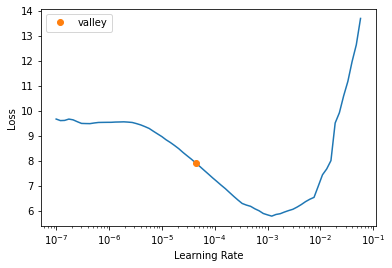

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 1e-4)

In [ ]:
learn.validate()

(#2) [0.061653994023799896,1.0635943412780762]

In [ ]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

In [ ]:
gen_summs = []
#mod:sharmaa4 for paper in tqdm(scis_df.text.values[:500]):
for paper in tqdm(scis_df.text.values[:5]):

  ARTICLE_TO_SUMMARIZE = paper
  inputs = tokenizer([ARTICLE_TO_SUMMARIZE], max_length=1024, return_tensors='pt', truncation=True)

  # Generate Summary
  summary_ids = model.generate(inputs['input_ids'], num_beams=4, max_length=500, early_stopping=True)
  gen_summs.append([tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids])

RuntimeError: ignored

In [ ]:
gen_df = pd.DataFrame({'generated_summary':gen_summs})
gen_df.head()

In [ ]:
gen_df.generated_summary = gen_df.generated_summary.apply(lambda x: x[0])
gen_df.head()

In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge2', 'rouge3'])
scores = []
#mod: sharmaa4 for i in range(500):
for i in range(5):
  
  scores.append(scorer.score(test_df.iloc[i].summary, gen_df.iloc[i].generated_summary))

In [ ]:
r2r = []
r2f = []
r3f = []
#mod:sharmaa4 for i in range(500):
for i in range(5):
  r2r.append(scores[i]['rouge2'].recall)
  r2f.append(scores[i]['rouge2'].fmeasure)
  r3f.append(scores[i]['rouge3'].fmeasure)

In [ ]:
print('rouge2 - recall: '+ str(np.mean(r2r)))
print('rouge2 - fmeasure: '+ str(np.mean(r2f)))
print('rouge3 - fmeasure: '+ str(np.mean(r3f)))

rouge2 - recall: 0.4764333337127982
rouge2 - fmeasure: 0.585565164569248
rouge3 - fmeasure: 0.569256056991675
